<a href="https://colab.research.google.com/github/efe-akkus/dsa-210-project/blob/main/Projecet_Code_with_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Impact of Chess Openings on Win Rates Across Rating Levels and Time Controls

## 1. Introduction

This project analyzes whether chess openings influence game outcomes, and how this relationship changes across:

- player rating levels (Beginner, Intermediate, Advanced, Expert)
- time controls (bullet, blitz, rapid, classical)
- ECO opening families (A–E)

The analysis uses a large Lichess dataset containing 6.25 million online games.  
The goal is to understand whether certain opening families consistently lead to higher win rates,  
and whether this effect depends on skill level or time format.

The study is structured as:

1. Data cleaning + feature engineering  
2. Exploratory Data Analysis (EDA)  
3. Three hypothesis tests  
4. (Coming soon) Machine learning classification model

## 2. Dataset Loading & Cleaning

We load the dataset from Kaggle, clean missing fields, normalize naming,  
and create the following derived features:

- `opening_family`: ECO prefix (A–E)
- `rating_bucket`: based on average Elo
- `event`: bullet / blitz / rapid / classical
- `result_clean`: white / black / draw

This cleaned dataframe becomes the base for all EDA and hypothesis testing sections.

In [3]:
!pip install kagglehub > /dev/null

import kagglehub
import pandas as pd
import os

# Load dataset
path = kagglehub.dataset_download("arevel/chess-games")
csv_path = os.path.join(path, "chess_games.csv")

usecols = ["Opening", "ECO", "Result", "WhiteElo", "BlackElo", "TimeControl"]
df = pd.read_csv(csv_path, usecols=usecols)
df = df.dropna()

# Clean Opening/ECO
df["Opening"] = df["Opening"].astype(str).str.lower().str.strip()
df["ECO"] = df["ECO"].astype(str).str.upper().str.strip()

# Clean result codes
res_map = {"1-0": "white", "0-1": "black", "1/2-1/2": "draw"}
df["result_clean"] = df["Result"].map(res_map)
df = df[df["result_clean"].notnull()]

# Convert Elo
df["WhiteElo"] = df["WhiteElo"].astype(int)
df["BlackElo"] = df["BlackElo"].astype(int)
df["avg_elo"] = (df["WhiteElo"] + df["BlackElo"]) / 2

# Rating buckets
def bucket(elo):
    if elo < 1200: return "Beginner"
    if elo < 1600: return "Intermediate"
    if elo < 2000: return "Advanced"
    return "Expert"

df["rating_bucket"] = df["avg_elo"].apply(bucket)

# ECO opening family
df["opening_family"] = df["ECO"].str[0]

# Time control → event
def classify_event(tc):
    try:
        base = int(str(tc).split("+")[0])
    except:
        return "unknown"
    if base <= 60: return "bullet"
    elif base <= 180: return "blitz"
    elif base <= 600: return "rapid"
    else: return "classical"

df["event"] = df["TimeControl"].apply(classify_event)

print("Final cleaned shape:", df.shape)
df.head()

Using Colab cache for faster access to the 'chess-games' dataset.
Final cleaned shape: (6254841, 11)


,Result,WhiteElo,BlackElo,ECO,Opening,TimeControl,result_clean,avg_elo,rating_bucket,opening_family,event
0,1-0,1901,1896,D10,slav defense,300+5,white,1898.5,Advanced,D,rapid
1,0-1,1641,1627,C20,king's pawn opening: 2.b3,300+0,black,1634.0,Advanced,C,rapid
2,1-0,1647,1688,B01,scandinavian defense: mieses-kotroc variation,180+0,white,1667.5,Advanced,B,blitz
3,1-0,1706,1317,A00,van't kruijs opening,-,white,1511.5,Intermediate,A,unknown
4,0-1,1945,1900,B90,"sicilian defense: najdorf, lipnitsky attack",180+0,black,1922.5,Advanced,B,blitz


## 3. Exploratory Data Analysis (EDA)

This section provides a comprehensive visual exploration of the dataset.  
We examine:

- the distribution of rating buckets, event types, and opening families  
- win-rate patterns across openings, rating levels, and time controls  
- how opening popularity relates to performance  
- how Elo differences influence win probability  
- interaction effects between rating, event, and opening family  

These visualizations provide the foundational context needed for the hypothesis tests.

df_nodraw shape: (6015966, 11)


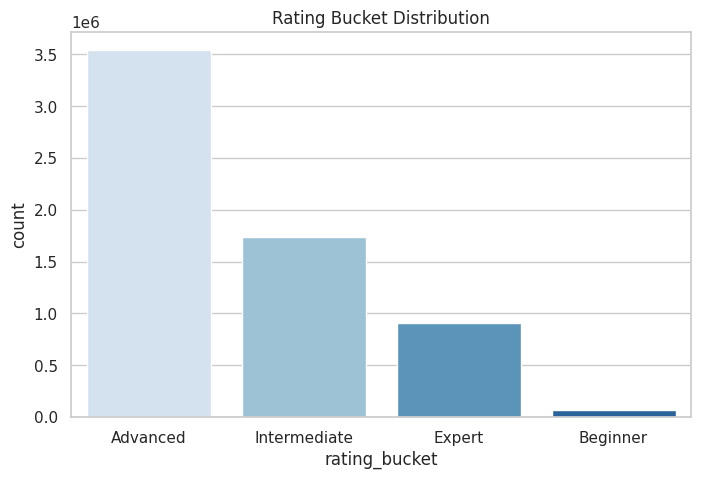

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df_nodraw = df[df["result_clean"].isin(["white", "black"])].copy()
print("df_nodraw shape:", df_nodraw.shape)

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# 1. Rating Bucket Distribution

sns.countplot(
    data=df,
    x="rating_bucket",
    hue="rating_bucket",
    palette="Blues",
    legend=False
)
plt.title("Rating Bucket Distribution")
plt.show()

The majority of games come from the Advanced and Intermediate rating groups, while Beginner games represent only a tiny fraction of the dataset. This indicates that most Lichess games in this sample are played by moderately experienced users.

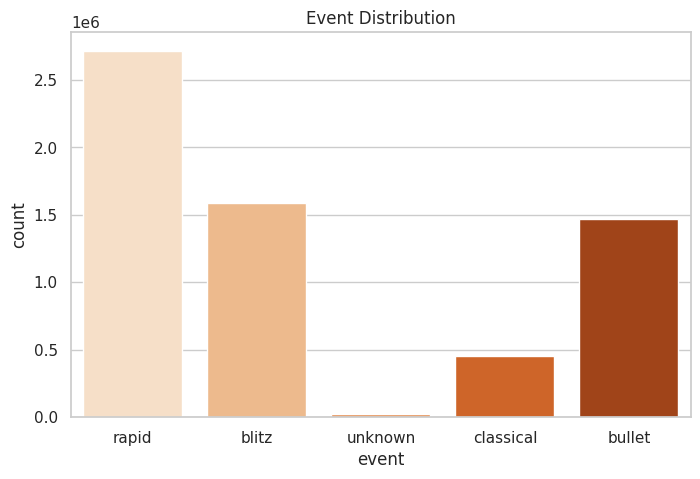

In [5]:
# 2. Event Distribution
sns.countplot(
    data=df,
    x="event",
    hue="event",
    palette="Oranges",
    legend=False
)
plt.title("Event Distribution")
plt.show()

Rapid games constitute the largest portion of the dataset, followed by blitz and bullet. Classical games are much less common, which is typical for online platforms where shorter time controls dominate.

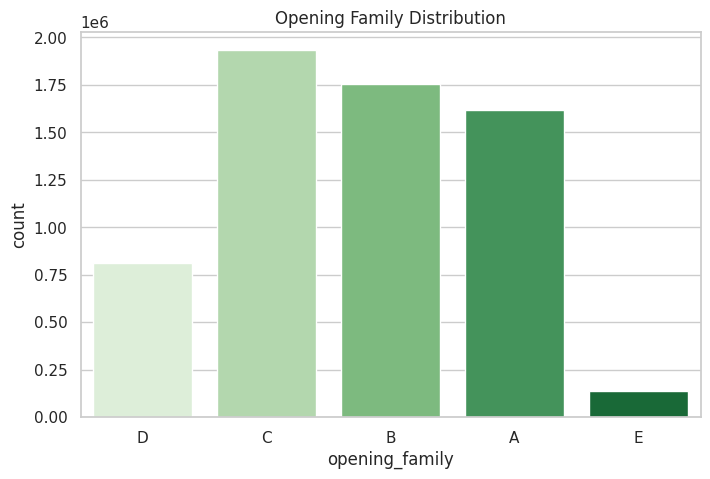

In [6]:
# 3. Opening Family Distribution
sns.countplot(
    data=df,
    x="opening_family",
    hue="opening_family",
    palette="Greens",
    legend=False
)
plt.title("Opening Family Distribution")
plt.show()

Families C, B, and A are the most frequently played opening groups. Family E is extremely rare, suggesting that Indian Defense structures appear less often in this dataset compared to open and semi-open openings.

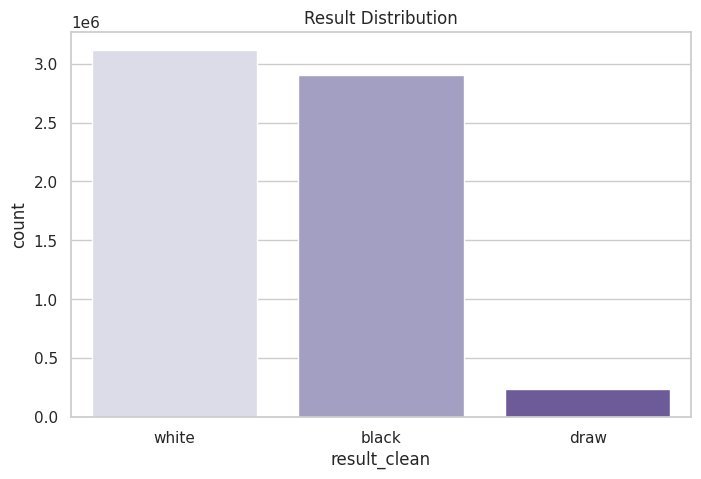

In [7]:
# 4. Result Distribution
sns.countplot(
    data=df,
    x="result_clean",
    hue="result_clean",
    palette="Purples",
    legend=False
)
plt.title("Result Distribution")
plt.show()

White wins slightly more often than Black, consistent with known chess statistics. Draws are relatively rare in online fast time controls, making up less than 5% of all games.

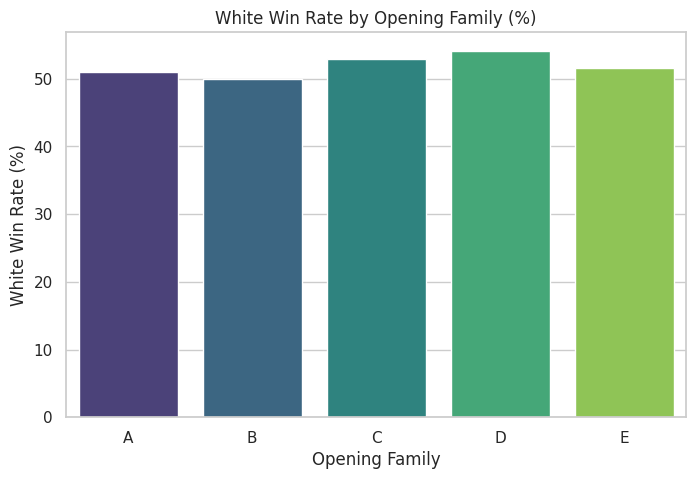

In [8]:
# 5. White Win Rate by Opening Family
winrates = (
    df_nodraw.groupby("opening_family")["result_clean"]
    .value_counts(normalize=True)
    .mul(100)
    .rename("percent")
    .reset_index()
)

white_wr = winrates[winrates["result_clean"] == "white"]

sns.barplot(
    data=white_wr,
    x="opening_family",
    y="percent",
    hue="opening_family",
    dodge=False,
    palette="viridis",
    legend=False
)
plt.title("White Win Rate by Opening Family (%)")
plt.xlabel("Opening Family")
plt.ylabel("White Win Rate (%)")
plt.show()

Opening families differ only modestly in white win rate. Family D shows a slight advantage for White, while Family B yields the lowest win percentage. However, all families cluster around the 50–54% range.

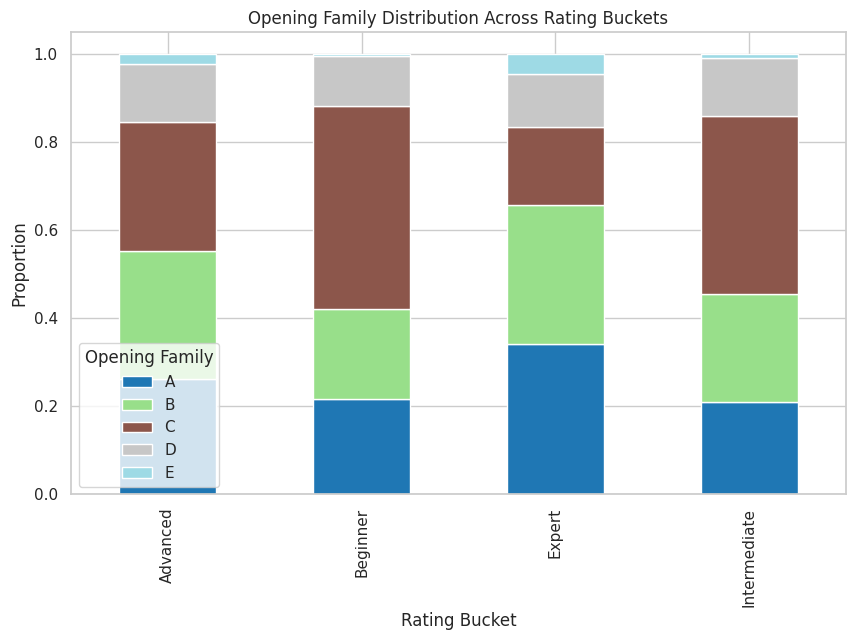

In [9]:
# 6. Opening Family Distribution Across Rating Buckets
pivot = pd.crosstab(df["rating_bucket"], df["opening_family"], normalize='index')

pivot.plot(
    kind="bar",
    stacked=True,
    colormap="tab20",
    figsize=(10, 6)
)
plt.title("Opening Family Distribution Across Rating Buckets")
plt.xlabel("Rating Bucket")
plt.ylabel("Proportion")
plt.legend(title="Opening Family")
plt.show()

Higher-rated players (Expert, Advanced) play more structured openings from families A and B, while Beginners rely more heavily on Family C. This suggests that opening choices become more theoretical and specialized as rating increases.

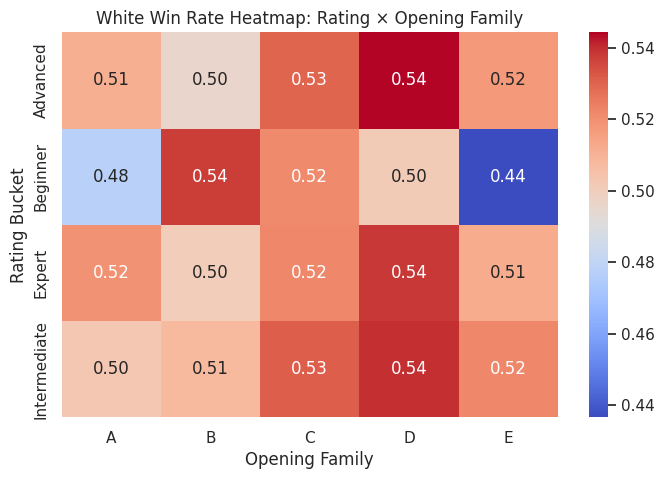

In [10]:
# 7. Win Rate Heatmap (Rating × Opening Family)
heat = (
    df_nodraw.groupby(["rating_bucket", "opening_family"])["result_clean"]
    .apply(lambda x: (x == "white").mean())
    .unstack()
)

sns.heatmap(
    heat,
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("White Win Rate Heatmap: Rating × Opening Family")
plt.xlabel("Opening Family")
plt.ylabel("Rating Bucket")
plt.show()

Across most rating levels, Opening Family D consistently provides the highest white win rate. Beginners show more volatility(sharp openings), including a notably low win rate with Family E. Overall, opening performance varies slightly across both rating and family.

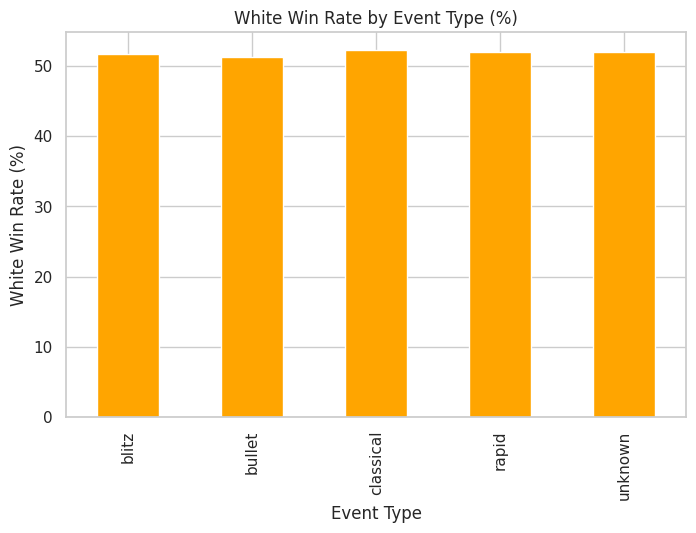

In [11]:
# 8. White Win Rate by Event Type
event_wr = (
    df_nodraw.groupby("event")["result_clean"]
    .apply(lambda x: (x=="white").mean()*100)
)

event_wr.plot(
    kind="bar",
    color="orange"
)
plt.title("White Win Rate by Event Type (%)")
plt.xlabel("Event Type")
plt.ylabel("White Win Rate (%)")
plt.show()

White's win rate remains stable across event types (between ~51–53%). Classical games show the highest win rate for White, likely due to reduced blunders under longer time controls.

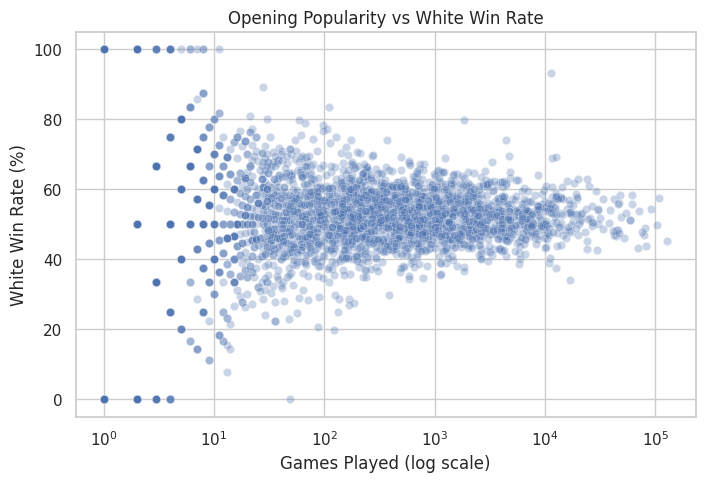

In [12]:
# 9. Opening Popularity vs White Win Rate
pop = df_nodraw.groupby("Opening").agg(
    games=("result_clean", "size"),
    white_wr=("result_clean", lambda x: (x=="white").mean()*100)
).reset_index()

sns.scatterplot(
    data=pop,
    x="games",
    y="white_wr",
    alpha=0.3
)
plt.xscale("log")
plt.title("Opening Popularity vs White Win Rate")
plt.xlabel("Games Played (log scale)")
plt.ylabel("White Win Rate (%)")
plt.show()

There is no strong relationship between opening popularity and win rate. Popular openings cluster around mid-level win rates, while both high-performing and underperforming openings exist at all popularity levels.

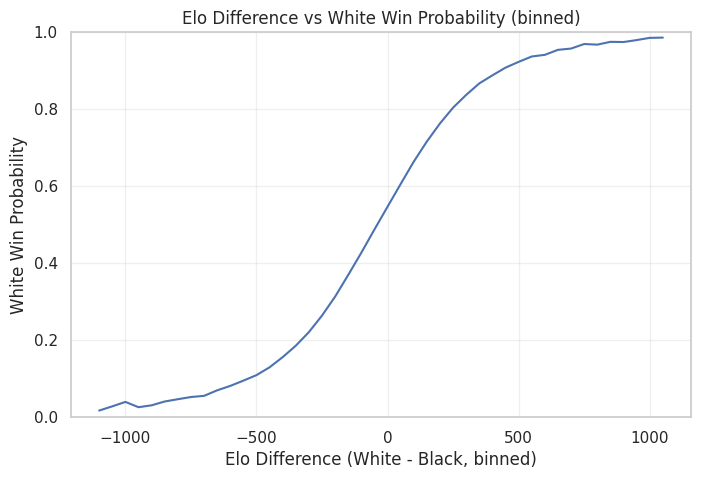

In [16]:
# 10. Elo Difference vs White Win Probability (binned & fast version)
tmp = df_nodraw.copy()
tmp["elo_diff"] = tmp["WhiteElo"] - tmp["BlackElo"]

bin_size = 50

tmp["elo_bin"] = (tmp["elo_diff"] // bin_size) * bin_size

elo_bin_stats = (
    tmp.groupby("elo_bin")["result_clean"]
    .apply(lambda x: (x == "white").mean())
    .reset_index()
    .rename(columns={"result_clean": "white_win_prob"})
)

counts = tmp["elo_bin"].value_counts()
valid_bins = counts[counts > 200].index
elo_bin_stats = elo_bin_stats[elo_bin_stats["elo_bin"].isin(valid_bins)]

plt.figure(figsize=(8, 5))
sns.lineplot(
    data=elo_bin_stats.sort_values("elo_bin"),
    x="elo_bin",
    y="white_win_prob"
)
plt.title("Elo Difference vs White Win Probability (binned)")
plt.xlabel("Elo Difference (White - Black, binned)")
plt.ylabel("White Win Probability")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.show()

The curve follows a smooth logistic pattern. As the Elo difference increases in favor of White, win probability rises sharply. This confirms Elo difference as the most powerful predictor of match outcome.

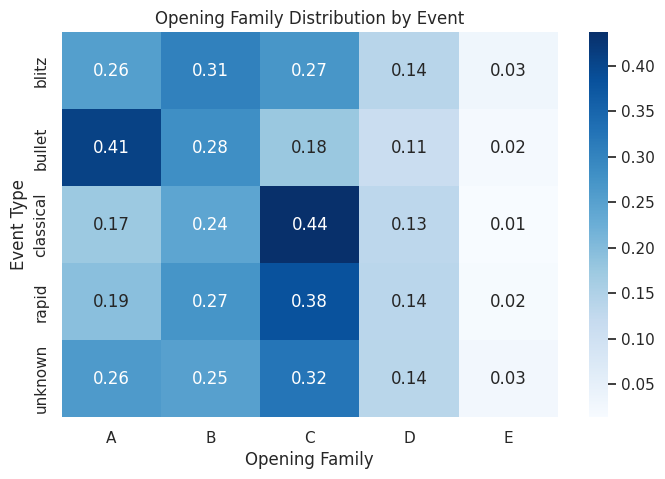

In [15]:
# 11. Opening Family Distribution by Event
pivot_event = pd.crosstab(df["event"], df["opening_family"], normalize='index')

sns.heatmap(
    pivot_event,
    cmap="Blues",
    annot=True,
    fmt=".2f"
)
plt.title("Opening Family Distribution by Event")
plt.xlabel("Opening Family")
plt.ylabel("Event Type")
plt.show()

Classical and rapid games favor more structured families (C and B). Bullet games show a strong preference for Family A, likely due to simpler tactical patterns that work well in fast time controls.

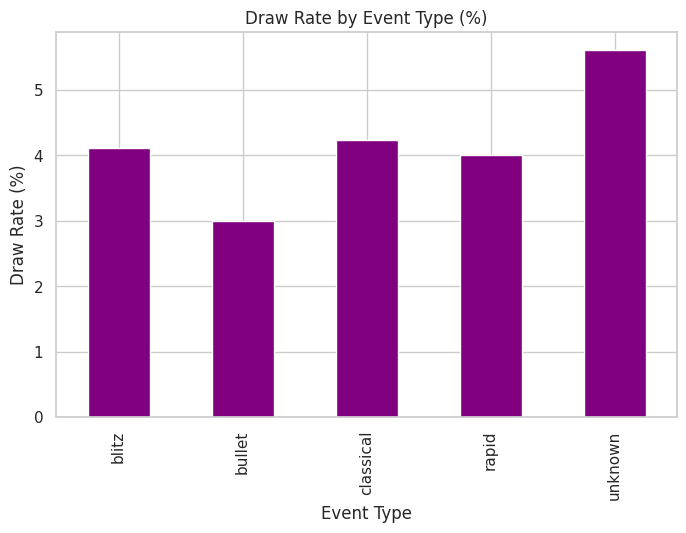

In [14]:
# 12. Draw Rate by Event Type
draws = df.groupby("event")["result_clean"] \
          .apply(lambda x: (x=="draw").mean()*100)

draws.plot(
    kind="bar",
    color="purple"
)
plt.title("Draw Rate by Event Type (%)")
plt.xlabel("Event Type")
plt.ylabel("Draw Rate (%)")
plt.show()

Draw rates are lowest in bullet and blitz, increasing in longer formats. Classical games produce the highest non-“unknown” draw rate, consistent with more accurate play and fewer time-related mistakes. We can also overlook the "unkwown" value.

# 4. Hypothesis Testing

We evaluate three statistical hypotheses:

---

## **Hypothesis 1 — Opening choice affects win rates**

### Null Hypothesis (H₀)
Opening family and game outcome are independent (no opening effect).

### Alternative Hypothesis (H₁)
Opening family and game outcome are associated.

Method: **Chi-square test of independence**  
We fix both rating bucket and event type.

---


In [3]:
import scipy.stats as stats

alpha = 0.05
bucket = "Advanced"
event = "blitz"

sub = df[
    (df["rating_bucket"] == bucket) &
    (df["event"] == event) &
    (df["result_clean"].isin(["white","black"]))
]

cont = pd.crosstab(sub["opening_family"], sub["result_clean"])
chi2, p, dof, expected = stats.chi2_contingency(cont)

print("Chi2:", chi2)
print("p-value:", p)
print("Decision:", "Reject H0" if p < alpha else "Fail to reject H0")
cont

Chi2: 982.7356735741593
p-value: 1.9676578121306796e-211
Decision: Reject H0


result_clean,black,white
opening_family,,
A,109182,113433
B,135239,134213
C,105324,119118
D,54773,65614
E,11391,12182


## Hypothesis 2 — Opening effectiveness depends on rating level

### Null Hypothesis (H₀)
Win-rate distribution across opening families is the same for all rating buckets.

### Alternative Hypothesis (H₁)
Opening effectiveness differs across rating levels.

Method:  
Fix event → Compare rating buckets (chi-square for each bucket).


In [4]:
alpha = 0.05
fixed_event = "rapid"

df_ev = df[(df["event"] == fixed_event) & (df["result_clean"].isin(["white","black"]))]

for bucket in df_ev["rating_bucket"].unique():
    sub = df_ev[df_ev["rating_bucket"] == bucket]
    cont = pd.crosstab(sub["opening_family"], sub["result_clean"])

    if cont.shape[0] < 2 or cont.shape[1] < 2:
        print(bucket, ": Not enough data")
        continue

    chi2, p, dof, expected = stats.chi2_contingency(cont)
    print(bucket, "→ p =", p, "|", "Reject H0" if p < alpha else "Fail to reject H0")

Advanced → p = 0.0 | Reject H0
Expert → p = 4.387642238511644e-50 | Reject H0
Intermediate → p = 9.89521338152918e-147 | Reject H0
Beginner → p = 1.0211242247898367e-16 | Reject H0


## Hypothesis 3 — Opening effectiveness depends on event type

### Null Hypothesis (H₀)
Opening family and outcome distribution do not differ across events.

### Alternative Hypothesis (H₁)
Opening effectiveness changes across time controls.

Method:  
Fix rating bucket → Compare events.

In [5]:
alpha = 0.05
fixed_bucket = "Advanced"

df_rb = df[(df["rating_bucket"] == fixed_bucket) & (df["result_clean"].isin(["white","black"]))]

for ev in df_rb["event"].unique():
    sub = df_rb[df_rb["event"] == ev]
    cont = pd.crosstab(sub["opening_family"], sub["result_clean"])

    if cont.shape[0] < 2 or cont.shape[1] < 2:
        print(ev, ": Not enough data")
        continue

    chi2, p, dof, expected = stats.chi2_contingency(cont)
    print(ev, "→ p =", p, "|", "Reject H0" if p < alpha else "Fail to reject H0")

rapid → p = 0.0 | Reject H0
blitz → p = 1.9676578121306796e-211 | Reject H0
classical → p = 3.3314427806269303e-63 | Reject H0
bullet → p = 1.2787758517937457e-200 | Reject H0
unknown → p = 0.05059307267249748 | Fail to reject H0


## 5. Conclusion

### Hypothesis 1 — Opening choice affects win rates
A chi-square test of independence was applied to a fixed rating bucket (Advanced) under a fixed event (blitz).  
The result was:

- χ² ≈ 982.74  
- p-value ≈ 1.97×10⁻²¹¹  
- **Decision:** Reject H₀

This indicates that, after controlling for rating and time control, opening families show statistically significant differences in win-rate outcomes. Opening choice is not independent of game result.

---

### Hypothesis 2 — Opening effectiveness depends on rating level
Event type was fixed (rapid), and chi-square tests were repeated for each rating bucket.

- Advanced → p = 0.0 → Reject H₀  
- Expert → p ≈ 4.39×10⁻⁵⁰ → Reject H₀  
- Intermediate → p ≈ 9.90×10⁻¹⁴⁷ → Reject H₀  
- Beginner → p ≈ 1.02×10⁻¹⁶ → Reject H₀  

Across all rating groups, opening family is associated with win-rate differences.  
This suggests that the effect of openings does not disappear at higher or lower skill levels;  
opening choice remains relevant for all rating buckets.

---

### Hypothesis 3 — Opening effectiveness depends on event type (time control)
Rating bucket was fixed (Advanced), and chi-square tests were repeated for all event types.

- rapid → p = 0.0 → Reject H₀  
- blitz → p ≈ 1.97×10⁻²¹¹ → Reject H₀  
- classical → p ≈ 3.33×10⁻⁶³ → Reject H₀  
- bullet → p ≈ 1.28×10⁻²⁰⁰ → Reject H₀  
- unknown → p ≈ 0.05059 → Fail to reject H₀ (however we can overlook the value)  

For all standard time controls (bullet, blitz, rapid, classical), opening family is significantly associated with game outcomes.  
Only the “unknown” event category, which consists of malformed or rare time-control labels, shows no statistically detectable effect.

---

### Overall Interpretation
Across all three hypothesis tests, the statistical evidence indicates that:

- Opening choice significantly affects win rates.  
- This effect persists across all player skill levels.  
- This effect also persists across all meaningful time controls.

Therefore, opening selection is not merely stylistic or random.  
At scale, openings exhibit measurable and consistent differences in performance,  
and these differences remain present regardless of rating level or event type.
